# Connectivity of the free attractor study
This is a notebook to study the effects of different parameters and the connectivity between the sequence and the free attractor. The parameters that seem relevant now are:
* Epochs
* kappa dynamics
* Length of the interval between patterns
* Length of the intervals between sequences at each epoch
* Dynamics of p 
* Number of minicolumns
* Size of the free attractor
* Training time

In [1]:
from __future__ import print_function
import pprint
import subprocess
import sys 
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

%matplotlib inline
matplotlib.rcParams.update({'font.size': 22})

np.set_printoptions(suppress=True, precision=2)

sns.set(font_scale=2.0)

#### Git machinery

In [2]:
run_old_version = False
if run_old_version:
    hash_when_file_was_written = '36023b14afbaa6a23aff7d9e885b41a6f835ed7e'
    hash_at_the_moment = subprocess.check_output(["git", 'rev-parse', 'HEAD']).strip()
    print('Actual hash', hash_at_the_moment)
    print('Hash of the commit used to run the simulation', hash_when_file_was_written)
    subprocess.call(['git', 'checkout', hash_when_file_was_written])

Now we import the functions that we use our library

In [3]:
from network import BCPNN, NetworkManager, BCPNNFast, Protocol
from data_transformer import build_ortogonal_patterns

from plotting_functions import plot_weight_matrix

from analysis_functions import calculate_total_connections, calculate_connections_free_attractor_to_first_pattern
from analysis_functions import calculate_connections_last_pattern_to_free_attractor
from analysis_functions import calculate_connections_among_free_attractor
from analysis_functions import calculate_connections_first_pattern_to_free_attractor

from analysis_functions import calculate_recall_sucess

## Epochs
First let's see the variation of the connectivity with the number of epochs

In [4]:
# Patterns parameters
hypercolumns = 4
minicolumns = 10
n_patterns = 5  # Number of patterns

# Manager properties
dt = 0.001
T_recalling = 3.0
values_to_save = ['o']

# Protocol
training_time = 0.1
inter_sequence_interval = 0.5
inter_pulse_interval = 0.0
epochs = 1

# Build patterns
patterns_dic = build_ortogonal_patterns(hypercolumns, minicolumns)
patterns = list(patterns_dic.values())
patterns = patterns[:n_patterns]

epochs_range = np.arange(1, 20, 2, dtype='int')

In [5]:
normalize = True
ampa = False
k_inner = True
p = 1

inter_sequence_connectivity = []
sequence_to_free_attractor_connectivity = []
free_attractor_to_sequence_connectivity = []
inter_free_attractor_connectiivty = []
first_state_to_free_attractor_connectivity = []
recall = []

for epochs in epochs_range:
    # Build the network
    nn = BCPNNFast(hypercolumns, minicolumns, k_inner=k_inner, p=p)

    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
    
    # Build the protocol for training
    protocol = Protocol()
    protocol.simple_protocol(patterns, training_time=training_time, inter_pulse_interval=inter_pulse_interval,
                             inter_sequence_interval=inter_sequence_interval, epochs=epochs)

    # Train
    manager.run_network_protocol(protocol=protocol, verbose=False)

    # Calculate the connections
    total = calculate_total_connections(manager, 0, 1, ampa=ampa, normalize=normalize)
    seq_to_attractor = calculate_connections_last_pattern_to_free_attractor(manager, ampa=ampa, normalize=normalize)
    attractor_to_seq = calculate_connections_free_attractor_to_first_pattern(manager, ampa=ampa, normalize=normalize)
    inter_free_attractor = calculate_connections_among_free_attractor(manager, ampa=ampa, normalize=normalize)
    aux = calculate_connections_first_pattern_to_free_attractor(manager, ampa=ampa, normalize=normalize)

    inter_sequence_connectivity.append(total)
    sequence_to_free_attractor_connectivity.append(seq_to_attractor)
    free_attractor_to_sequence_connectivity.append(attractor_to_seq)
    inter_free_attractor_connectiivty.append(inter_free_attractor)
    first_state_to_free_attractor_connectivity.append(aux)
    
    # Calculate correct recall
    pattern = [0, 1, 2, 3, 4]
    success_rate = calculate_recall_sucess(manager, T_recalling=T_recalling,
                                      I_cue=patterns[0], T_cue=0.1, n=10, pattern=pattern)
    recall.append([epochs, success_rate])

../analysis_functions.py:39: RuntimeWarning: invalid value encountered in double_scalars
  dis = [a / b for (a, b) in zip(nominator, denominator)]


epochs [ 1  3  5  7  9 11 13 15 17 19]
succesfull recall [[1, 20.0], [3, 0.0], [5, 0.0], [7, 0.0], [9, 100.0], [11, 100.0], [13, 100.0], [15, 100.0], [17, 0.0], [19, 0.0]]


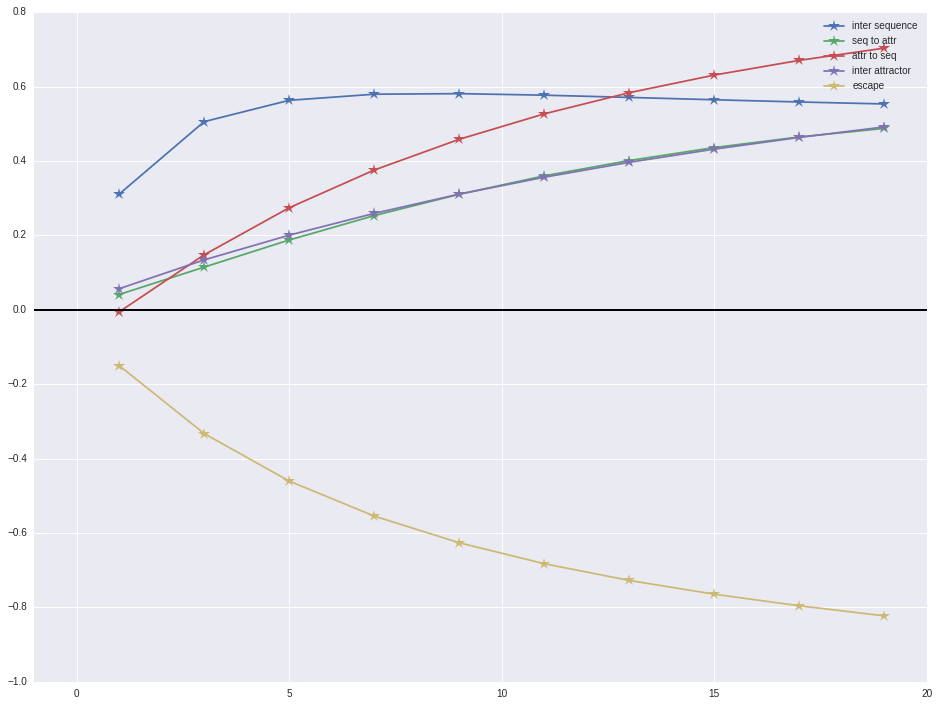

In [6]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(epochs_range, inter_sequence_connectivity, '*-', markersize=12, label='inter sequence')
ax.plot(epochs_range, sequence_to_free_attractor_connectivity, '*-', markersize=12, label='seq to attr')
ax.plot(epochs_range, free_attractor_to_sequence_connectivity, '*-', markersize=12, label='attr to seq')
ax.plot(epochs_range, inter_free_attractor_connectiivty, '*-', markersize=12, label='inter attractor')
ax.plot(epochs_range, first_state_to_free_attractor_connectivity, '*-', markersize=12, label='escape')

ax.axhline(0, color='k', linewidth=2)

ax.set_xlim([-1, epochs_range[-1] + 1])
ax.legend()

print('epochs', epochs_range)
print('succesfull recall', recall)

#### K inner
Let's the network keep updating the values of the probabilities even in the inter-sequence intervals

In [7]:
normalize = True
ampa = False
k_inner = False
p = 1

inter_sequence_connectivity = []
sequence_to_free_attractor_connectivity = []
free_attractor_to_sequence_connectivity = []
inter_free_attractor_connectiivty = []
first_state_to_free_attractor_connectivity = []
recall = []

for epochs in epochs_range:
    # Build the network
    nn = BCPNNFast(hypercolumns, minicolumns, k_inner=k_inner, p=p)

    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
    
    # Build the protocol for training
    protocol = Protocol()
    protocol.simple_protocol(patterns, training_time=training_time, inter_pulse_interval=inter_pulse_interval,
                             inter_sequence_interval=inter_sequence_interval, epochs=epochs)

    # Train
    manager.run_network_protocol(protocol=protocol, verbose=False)

    # Calculate the connections
    total = calculate_total_connections(manager, 0, 1, ampa=ampa, normalize=normalize)
    seq_to_attractor = calculate_connections_last_pattern_to_free_attractor(manager, ampa=ampa, normalize=normalize)
    attractor_to_seq = calculate_connections_free_attractor_to_first_pattern(manager, ampa=ampa, normalize=normalize)
    inter_free_attractor = calculate_connections_among_free_attractor(manager, ampa=ampa, normalize=normalize)
    aux = calculate_connections_first_pattern_to_free_attractor(manager, ampa=ampa, normalize=normalize)

    inter_sequence_connectivity.append(total)
    sequence_to_free_attractor_connectivity.append(seq_to_attractor)
    free_attractor_to_sequence_connectivity.append(attractor_to_seq)
    inter_free_attractor_connectiivty.append(inter_free_attractor)
    first_state_to_free_attractor_connectivity.append(aux)
    
    # Calculate correct recall
    pattern = [0, 1, 2, 3, 4]
    success_rate = calculate_recall_sucess(manager, T_recalling=T_recalling,
                                      I_cue=patterns[0], T_cue=0.1, n=10, pattern=pattern)
    recall.append([epochs, success_rate])

epochs [ 1  3  5  7  9 11 13 15 17 19]
succesfull recall [[1, 0.0], [3, 100.0], [5, 100.0], [7, 100.0], [9, 100.0], [11, 100.0], [13, 100.0], [15, 100.0], [17, 100.0], [19, 100.0]]


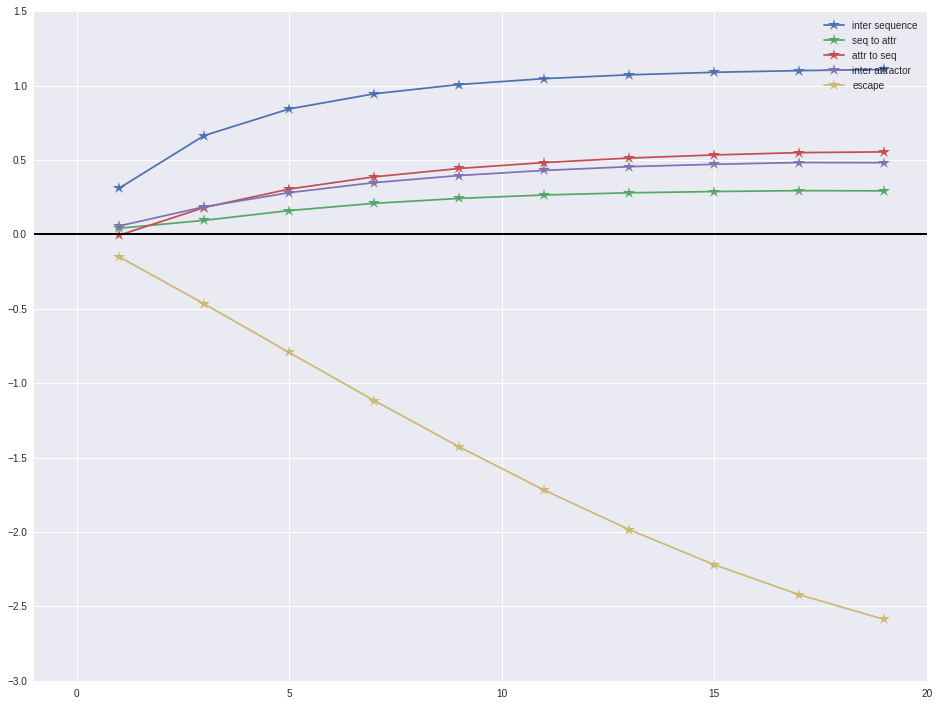

In [8]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(epochs_range, inter_sequence_connectivity, '*-', markersize=12, label='inter sequence')
ax.plot(epochs_range, sequence_to_free_attractor_connectivity, '*-', markersize=12, label='seq to attr')
ax.plot(epochs_range, free_attractor_to_sequence_connectivity, '*-', markersize=12, label='attr to seq')
ax.plot(epochs_range, inter_free_attractor_connectiivty, '*-', markersize=12, label='inter attractor')
ax.plot(epochs_range, first_state_to_free_attractor_connectivity, '*-', markersize=12, label='escape')

ax.axhline(0, color='k', linewidth=2)

ax.set_xlim([-1, epochs_range[-1] + 1])
ax.legend()

print('epochs', epochs_range)
print('succesfull recall', recall)

#### Effect of p 
The network effect of discounting initial effects in connectivity

In [9]:
normalize = True
ampa = False
k_inner = True
p = 0

inter_sequence_connectivity = []
sequence_to_free_attractor_connectivity = []
free_attractor_to_sequence_connectivity = []
inter_free_attractor_connectiivty = []
first_state_to_free_attractor_connectivity = []
recall = []

for epochs in epochs_range:
    # Build the network
    nn = BCPNNFast(hypercolumns, minicolumns, k_inner=k_inner, p=p)

    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
    
    # Build the protocol for training
    protocol = Protocol()
    protocol.simple_protocol(patterns, training_time=training_time, inter_pulse_interval=inter_pulse_interval,
                             inter_sequence_interval=inter_sequence_interval, epochs=epochs)

    # Train
    manager.run_network_protocol(protocol=protocol, verbose=False)

    # Calculate the connections
    total = calculate_total_connections(manager, 0, 1, ampa=ampa, normalize=normalize)
    seq_to_attractor = calculate_connections_last_pattern_to_free_attractor(manager, ampa=ampa, normalize=normalize)
    attractor_to_seq = calculate_connections_free_attractor_to_first_pattern(manager, ampa=ampa, normalize=normalize)
    inter_free_attractor = calculate_connections_among_free_attractor(manager, ampa=ampa, normalize=normalize)
    aux = calculate_connections_first_pattern_to_free_attractor(manager, ampa=ampa, normalize=normalize)

    inter_sequence_connectivity.append(total)
    sequence_to_free_attractor_connectivity.append(seq_to_attractor)
    free_attractor_to_sequence_connectivity.append(attractor_to_seq)
    inter_free_attractor_connectiivty.append(inter_free_attractor)
    first_state_to_free_attractor_connectivity.append(aux)
    
    # Calculate correct recall
    pattern = [0, 1, 2, 3, 4]
    success_rate = calculate_recall_sucess(manager, T_recalling=T_recalling,
                                      I_cue=patterns[0], T_cue=0.1, n=10, pattern=pattern)
    recall.append([epochs, success_rate])

epochs [ 1  3  5  7  9 11 13 15 17 19]
succesfull recall [[1, 20.0], [3, 100.0], [5, 40.0], [7, 0.0], [9, 100.0], [11, 100.0], [13, 100.0], [15, 100.0], [17, 0.0], [19, 0.0]]


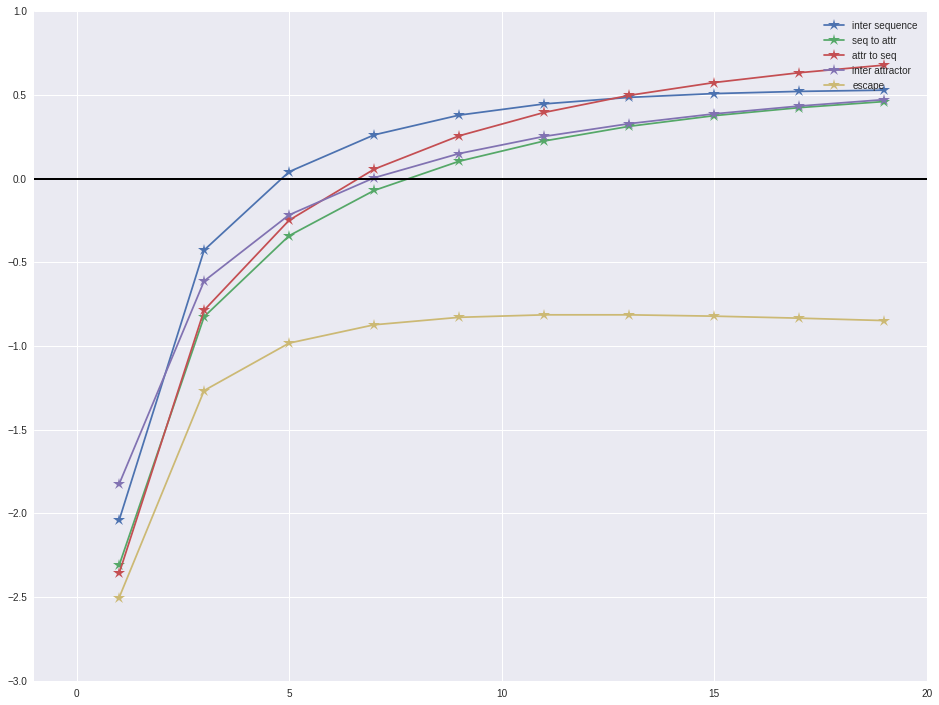

In [10]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(epochs_range, inter_sequence_connectivity, '*-', markersize=12, label='inter sequence')
ax.plot(epochs_range, sequence_to_free_attractor_connectivity, '*-', markersize=12, label='seq to attr')
ax.plot(epochs_range, free_attractor_to_sequence_connectivity, '*-', markersize=12, label='attr to seq')
ax.plot(epochs_range, inter_free_attractor_connectiivty, '*-', markersize=12, label='inter attractor')
ax.plot(epochs_range, first_state_to_free_attractor_connectivity, '*-', markersize=12, label='escape')

ax.axhline(0, color='k', linewidth=2)

ax.set_xlim([-1, epochs_range[-1] + 1])
ax.legend()

print('epochs', epochs_range)
print('succesfull recall', recall)

## Inter Sequence Interval

In [11]:
# Patterns parameters
hypercolumns = 4
minicolumns = 10
n_patterns = 5  # Number of patterns

# Manager properties
dt = 0.001
T_recalling = 3.0
values_to_save = ['o']

# Protocol
training_time = 0.1
inter_sequence_interval = 0.0
inter_pulse_interval = 0.0
epochs = 3

# Build patterns
patterns_dic = build_ortogonal_patterns(hypercolumns, minicolumns)
patterns = list(patterns_dic.values())
patterns = patterns[:n_patterns]

inter_sequence_interval_ranges = np.arange(0, 10.5, 0.5)

In [12]:
normalize = True
ampa = False
k_inner = True
p = 1

inter_sequence_connectivity = []
sequence_to_free_attractor_connectivity = []
free_attractor_to_sequence_connectivity = []
inter_free_attractor_connectiivty = []
first_state_to_free_attractor_connectivity = []
recall = []

for inter_sequence_interval in inter_sequence_interval_ranges:
    # Build the network
    nn = BCPNNFast(hypercolumns, minicolumns, k_inner=k_inner, p=p)

    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
    
    # Build the protocol for training
    protocol = Protocol()
    protocol.simple_protocol(patterns, training_time=training_time, inter_pulse_interval=inter_pulse_interval,
                             inter_sequence_interval=inter_sequence_interval, epochs=epochs)

    # Train
    manager.run_network_protocol(protocol=protocol, verbose=False)

    # Calculate the connections
    total = calculate_total_connections(manager, 0, 1, ampa=ampa, normalize=normalize)
    seq_to_attractor = calculate_connections_last_pattern_to_free_attractor(manager, ampa=ampa, normalize=normalize)
    attractor_to_seq = calculate_connections_free_attractor_to_first_pattern(manager, ampa=ampa, normalize=normalize)
    inter_free_attractor = calculate_connections_among_free_attractor(manager, ampa=ampa, normalize=normalize)
    aux = calculate_connections_first_pattern_to_free_attractor(manager, ampa=ampa, normalize=normalize)

    inter_sequence_connectivity.append(total)
    sequence_to_free_attractor_connectivity.append(seq_to_attractor)
    free_attractor_to_sequence_connectivity.append(attractor_to_seq)
    inter_free_attractor_connectiivty.append(inter_free_attractor)
    first_state_to_free_attractor_connectivity.append(aux)
    
    # Calculate correct recall
    pattern = [0, 1, 2, 3, 4]
    success_rate = calculate_recall_sucess(manager, T_recalling=T_recalling,
                                      I_cue=patterns[0], T_cue=0.1, n=10, pattern=pattern)
    recall.append([inter_sequence_interval, success_rate])

inter sequence interval [  0.    0.5   1.    1.5   2.    2.5   3.    3.5   4.    4.5   5.    5.5
   6.    6.5   7.    7.5   8.    8.5   9.    9.5  10. ]
sucesfful recall [[0.0, 40.0], [0.5, 0.0], [1.0, 0.0], [1.5, 0.0], [2.0, 0.0], [2.5, 0.0], [3.0, 0.0], [3.5, 0.0], [4.0, 0.0], [4.5, 0.0], [5.0, 0.0], [5.5, 10.0], [6.0, 0.0], [6.5, 10.0], [7.0, 10.0], [7.5, 0.0], [8.0, 0.0], [8.5, 10.0], [9.0, 0.0], [9.5, 0.0], [10.0, 0.0]]


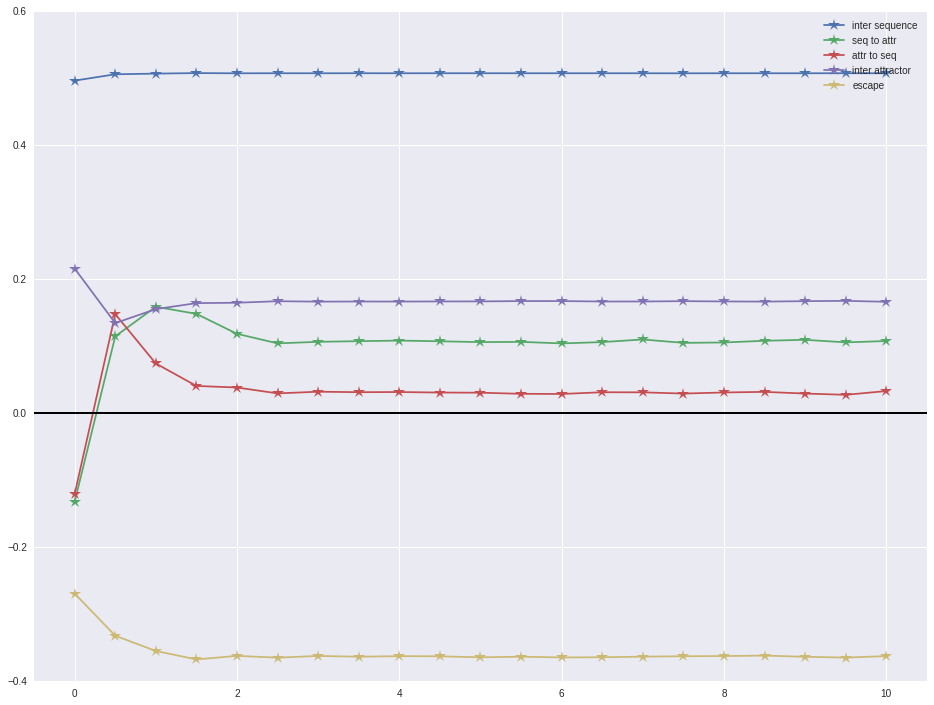

In [13]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(inter_sequence_interval_ranges, inter_sequence_connectivity, '*-', markersize=12, label='inter sequence')
ax.plot(inter_sequence_interval_ranges, sequence_to_free_attractor_connectivity, '*-', markersize=12, label='seq to attr')
ax.plot(inter_sequence_interval_ranges, free_attractor_to_sequence_connectivity, '*-', markersize=12, label='attr to seq')
ax.plot(inter_sequence_interval_ranges, inter_free_attractor_connectiivty, '*-', markersize=12, label='inter attractor')
ax.plot(inter_sequence_interval_ranges, first_state_to_free_attractor_connectivity, '*-', markersize=12, label='escape')

ax.axhline(0, color='k', linewidth=2)

ax.set_xlim([-0.5, inter_sequence_interval_ranges[-1] + 0.5])
ax.legend()

print('inter sequence interval', inter_sequence_interval_ranges)
print('sucesfful recall', recall)

#### Effect of k_inner

In [14]:
normalize = True
ampa = False
k_inner = False
p = 1

inter_sequence_connectivity = []
sequence_to_free_attractor_connectivity = []
free_attractor_to_sequence_connectivity = []
inter_free_attractor_connectiivty = []
first_state_to_free_attractor_connectivity = []
recall = []

for inter_sequence_interval in inter_sequence_interval_ranges:
    # Build the network
    nn = BCPNNFast(hypercolumns, minicolumns, k_inner=k_inner, p=p)

    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
    
    # Build the protocol for training
    protocol = Protocol()
    protocol.simple_protocol(patterns, training_time=training_time, inter_pulse_interval=inter_pulse_interval,
                             inter_sequence_interval=inter_sequence_interval, epochs=epochs)

    # Train
    manager.run_network_protocol(protocol=protocol, verbose=False)

    # Calculate the connections
    total = calculate_total_connections(manager, 0, 1, ampa=ampa, normalize=normalize)
    seq_to_attractor = calculate_connections_last_pattern_to_free_attractor(manager, ampa=ampa, normalize=normalize)
    attractor_to_seq = calculate_connections_free_attractor_to_first_pattern(manager, ampa=ampa, normalize=normalize)
    inter_free_attractor = calculate_connections_among_free_attractor(manager, ampa=ampa, normalize=normalize)
    aux = calculate_connections_first_pattern_to_free_attractor(manager, ampa=ampa, normalize=normalize)

    inter_sequence_connectivity.append(total)
    sequence_to_free_attractor_connectivity.append(seq_to_attractor)
    free_attractor_to_sequence_connectivity.append(attractor_to_seq)
    inter_free_attractor_connectiivty.append(inter_free_attractor)
    first_state_to_free_attractor_connectivity.append(aux)
    
    # Calculate correct recall
    pattern = [0, 1, 2, 3, 4]
    success_rate = calculate_recall_sucess(manager, T_recalling=T_recalling,
                                      I_cue=patterns[0], T_cue=0.1, n=10, pattern=pattern)
    recall.append([inter_sequence_interval, success_rate])

inter sequence interval [  0.    0.5   1.    1.5   2.    2.5   3.    3.5   4.    4.5   5.    5.5
   6.    6.5   7.    7.5   8.    8.5   9.    9.5  10. ]
succesfful recall [[0.0, 10.0], [0.5, 100.0], [1.0, 100.0], [1.5, 100.0], [2.0, 100.0], [2.5, 100.0], [3.0, 100.0], [3.5, 100.0], [4.0, 90.0], [4.5, 100.0], [5.0, 80.0], [5.5, 90.0], [6.0, 70.0], [6.5, 90.0], [7.0, 40.0], [7.5, 40.0], [8.0, 80.0], [8.5, 50.0], [9.0, 70.0], [9.5, 60.0], [10.0, 60.0]]


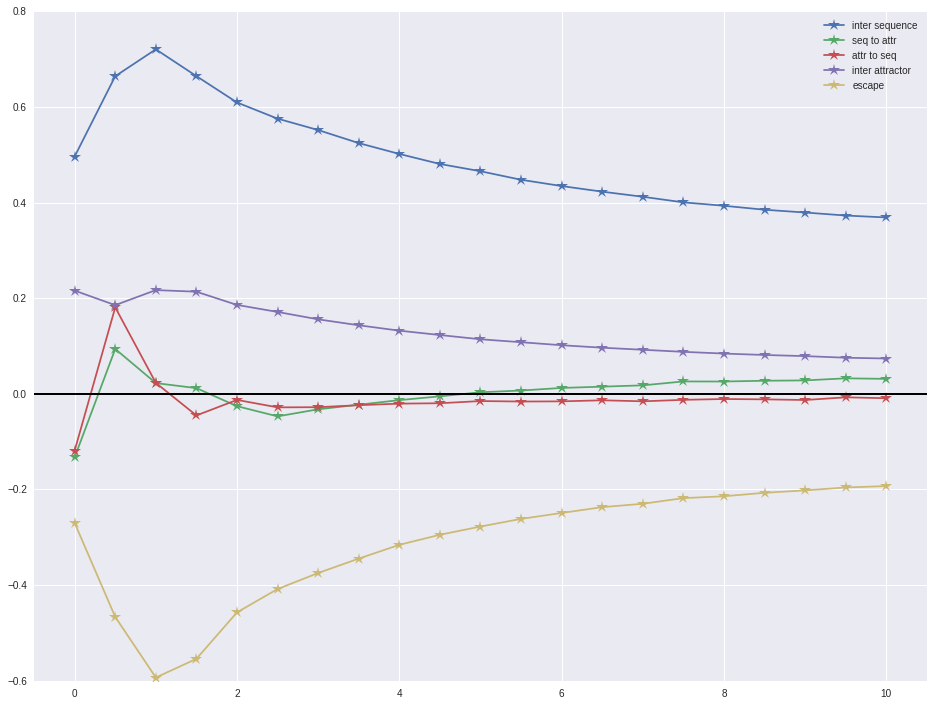

In [15]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(inter_sequence_interval_ranges, inter_sequence_connectivity, '*-', markersize=12, label='inter sequence')
ax.plot(inter_sequence_interval_ranges, sequence_to_free_attractor_connectivity, '*-', markersize=12, label='seq to attr')
ax.plot(inter_sequence_interval_ranges, free_attractor_to_sequence_connectivity, '*-', markersize=12, label='attr to seq')
ax.plot(inter_sequence_interval_ranges, inter_free_attractor_connectiivty, '*-', markersize=12, label='inter attractor')
ax.plot(inter_sequence_interval_ranges, first_state_to_free_attractor_connectivity, '*-', markersize=12, label='escape')

ax.axhline(0, color='k', linewidth=2)

ax.set_xlim([-0.5, inter_sequence_interval_ranges[-1] + 0.5])
ax.legend()

print('inter sequence interval', inter_sequence_interval_ranges)
print('succesfful recall', recall)

#### Effect of p

In [16]:
normalize = True
ampa = False
k_inner = True
p = 0.0

inter_sequence_connectivity = []
sequence_to_free_attractor_connectivity = []
free_attractor_to_sequence_connectivity = []
inter_free_attractor_connectiivty = []
first_state_to_free_attractor_connectivity = []
recall = []

for inter_sequence_interval in inter_sequence_interval_ranges:
    # Build the network
    nn = BCPNNFast(hypercolumns, minicolumns, k_inner=k_inner, p=p)

    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
    
    # Build the protocol for training
    protocol = Protocol()
    protocol.simple_protocol(patterns, training_time=training_time, inter_pulse_interval=inter_pulse_interval,
                             inter_sequence_interval=inter_sequence_interval, epochs=epochs)

    # Train
    manager.run_network_protocol(protocol=protocol, verbose=False)

    # Calculate the connections
    total = calculate_total_connections(manager, 0, 1, ampa=ampa, normalize=normalize)
    seq_to_attractor = calculate_connections_last_pattern_to_free_attractor(manager, ampa=ampa, normalize=normalize)
    attractor_to_seq = calculate_connections_free_attractor_to_first_pattern(manager, ampa=ampa, normalize=normalize)
    inter_free_attractor = calculate_connections_among_free_attractor(manager, ampa=ampa, normalize=normalize)
    aux = calculate_connections_first_pattern_to_free_attractor(manager, ampa=ampa, normalize=normalize)

    inter_sequence_connectivity.append(total)
    sequence_to_free_attractor_connectivity.append(seq_to_attractor)
    free_attractor_to_sequence_connectivity.append(attractor_to_seq)
    inter_free_attractor_connectiivty.append(inter_free_attractor)
    first_state_to_free_attractor_connectivity.append(aux)
    
    # Calculate correct recall
    pattern = [0, 1, 2, 3, 4]
    success_rate = calculate_recall_sucess(manager, T_recalling=T_recalling,
                                      I_cue=patterns[0], T_cue=0.1, n=10, pattern=pattern)
    recall.append([inter_sequence_interval, success_rate])

inter sequence interval [  0.    0.5   1.    1.5   2.    2.5   3.    3.5   4.    4.5   5.    5.5
   6.    6.5   7.    7.5   8.    8.5   9.    9.5  10. ]
sucesfful recall [[0.0, 100.0], [0.5, 100.0], [1.0, 70.0], [1.5, 60.0], [2.0, 70.0], [2.5, 20.0], [3.0, 10.0], [3.5, 0.0], [4.0, 20.0], [4.5, 10.0], [5.0, 0.0], [5.5, 0.0], [6.0, 0.0], [6.5, 0.0], [7.0, 0.0], [7.5, 0.0], [8.0, 0.0], [8.5, 0.0], [9.0, 0.0], [9.5, 0.0], [10.0, 0.0]]


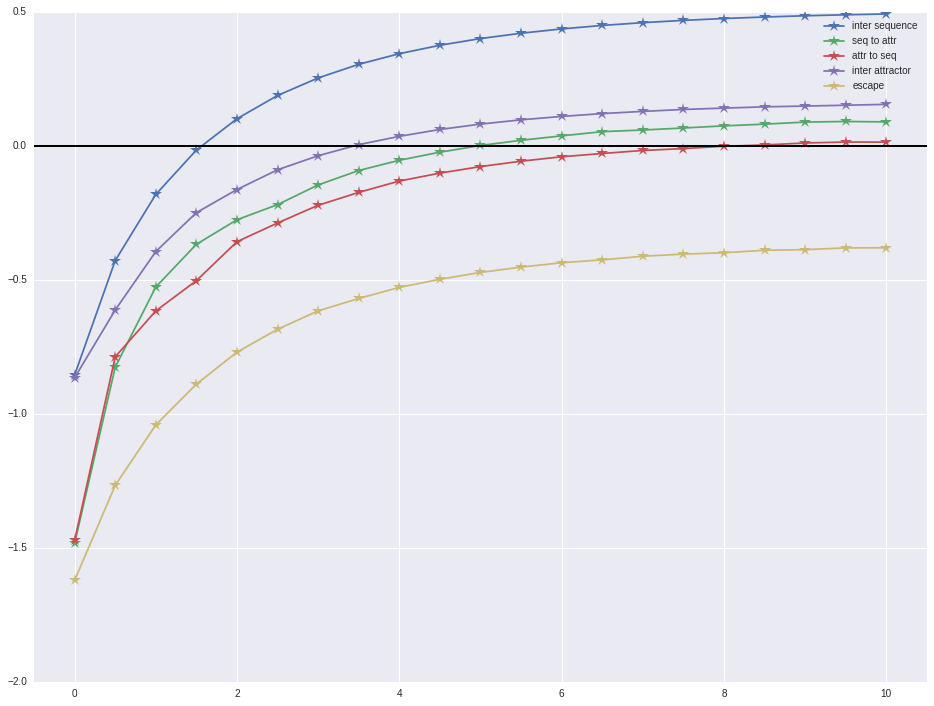

In [17]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(inter_sequence_interval_ranges, inter_sequence_connectivity, '*-', markersize=12, label='inter sequence')
ax.plot(inter_sequence_interval_ranges, sequence_to_free_attractor_connectivity, '*-', markersize=12, label='seq to attr')
ax.plot(inter_sequence_interval_ranges, free_attractor_to_sequence_connectivity, '*-', markersize=12, label='attr to seq')
ax.plot(inter_sequence_interval_ranges, inter_free_attractor_connectiivty, '*-', markersize=12, label='inter attractor')
ax.plot(inter_sequence_interval_ranges, first_state_to_free_attractor_connectivity, '*-', markersize=12, label='escape')

ax.axhline(0, color='k', linewidth=2)

ax.set_xlim([-0.5, inter_sequence_interval_ranges[-1] + 0.5])
ax.legend()

print('inter sequence interval', inter_sequence_interval_ranges)
print('sucesfful recall', recall)

## Inter pattern interval

In [18]:
# Patterns parameters
hypercolumns = 4
minicolumns = 10
n_patterns = 5  # Number of patterns

# Manager properties
dt = 0.001
T_recalling = 3.0
values_to_save = ['o']

# Protocol
training_time = 0.1
inter_sequence_interval = 0.5
inter_pulse_interval = 0.0
epochs = 5

# Build patterns
patterns_dic = build_ortogonal_patterns(hypercolumns, minicolumns)
patterns = list(patterns_dic.values())
patterns = patterns[:n_patterns]

inter_pulse_interval_ranges = np.arange(0, 2.1, 0.1)

In [19]:
normalize = True
ampa = False
k_inner = True
p = 1.0


inter_sequence_connectivity = []
sequence_to_free_attractor_connectivity = []
free_attractor_to_sequence_connectivity = []
inter_free_attractor_connectiivty = []
first_state_to_free_attractor_connectivity = []
recall = []

for inter_pulse_interval in inter_pulse_interval_ranges:
    # Build the network
    nn = BCPNNFast(hypercolumns, minicolumns, k_inner=k_inner, p=p)

    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
    
    # Build the protocol for training
    protocol = Protocol()
    protocol.simple_protocol(patterns, training_time=training_time, inter_pulse_interval=inter_pulse_interval,
                             inter_sequence_interval=inter_sequence_interval, epochs=epochs)

    # Train
    manager.run_network_protocol(protocol=protocol, verbose=False)

    # Calculate the connections
    total = calculate_total_connections(manager, 0, 1, ampa=ampa, normalize=normalize)
    seq_to_attractor = calculate_connections_last_pattern_to_free_attractor(manager, ampa=ampa, normalize=normalize)
    attractor_to_seq = calculate_connections_free_attractor_to_first_pattern(manager, ampa=ampa, normalize=normalize)
    inter_free_attractor = calculate_connections_among_free_attractor(manager, ampa=ampa, normalize=normalize)
    aux = calculate_connections_first_pattern_to_free_attractor(manager, ampa=ampa, normalize=normalize)

    inter_sequence_connectivity.append(total)
    sequence_to_free_attractor_connectivity.append(seq_to_attractor)
    free_attractor_to_sequence_connectivity.append(attractor_to_seq)
    inter_free_attractor_connectiivty.append(inter_free_attractor)
    first_state_to_free_attractor_connectivity.append(aux)
    
    # Calculate correct recall
    pattern = [0, 1, 2, 3, 4]
    success_rate = calculate_recall_sucess(manager, T_recalling=T_recalling,
                                      I_cue=patterns[0], T_cue=0.1, n=10, pattern=pattern)
    recall.append([inter_pulse_interval, success_rate])

[[0.0, 0.0], [0.10000000000000001, 100.0], [0.20000000000000001, 40.0], [0.30000000000000004, 10.0], [0.40000000000000002, 0.0], [0.5, 10.0], [0.60000000000000009, 20.0], [0.70000000000000007, 0.0], [0.80000000000000004, 0.0], [0.90000000000000002, 0.0], [1.0, 0.0], [1.1000000000000001, 0.0], [1.2000000000000002, 0.0], [1.3, 0.0], [1.4000000000000001, 0.0], [1.5, 0.0], [1.6000000000000001, 0.0], [1.7000000000000002, 0.0], [1.8, 0.0], [1.9000000000000001, 0.0], [2.0, 0.0]]


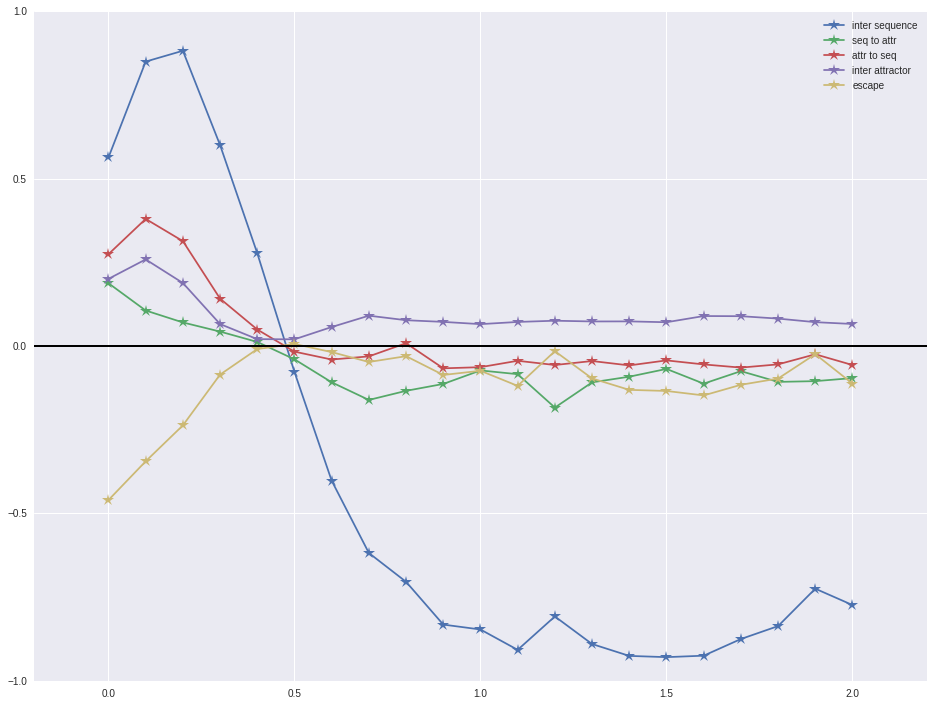

In [20]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(inter_pulse_interval_ranges, inter_sequence_connectivity, '*-', markersize=12, label='inter sequence')
ax.plot(inter_pulse_interval_ranges, sequence_to_free_attractor_connectivity, '*-', markersize=12, label='seq to attr')
ax.plot(inter_pulse_interval_ranges, free_attractor_to_sequence_connectivity, '*-', markersize=12, label='attr to seq')
ax.plot(inter_pulse_interval_ranges, inter_free_attractor_connectiivty, '*-', markersize=12, label='inter attractor')
ax.plot(inter_pulse_interval_ranges, first_state_to_free_attractor_connectivity, '*-', markersize=12, label='escape')

ax.axhline(0, color='k', linewidth=2)

ax.set_xlim([-0.2, inter_pulse_interval_ranges[-1] + 0.2])
ax.legend()

print(recall)

##### Effect of k_inner

In [21]:
normalize = True
ampa = False
k_inner = False
p = 1.0


inter_sequence_connectivity = []
sequence_to_free_attractor_connectivity = []
free_attractor_to_sequence_connectivity = []
inter_free_attractor_connectiivty = []
first_state_to_free_attractor_connectivity = []
recall = []

for inter_pulse_interval in inter_pulse_interval_ranges:
    # Build the network
    nn = BCPNNFast(hypercolumns, minicolumns, k_inner=k_inner, p=p)

    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
    
    # Build the protocol for training
    protocol = Protocol()
    protocol.simple_protocol(patterns, training_time=training_time, inter_pulse_interval=inter_pulse_interval,
                             inter_sequence_interval=inter_sequence_interval, epochs=epochs)

    # Train
    manager.run_network_protocol(protocol=protocol, verbose=False)

    # Calculate the connections
    total = calculate_total_connections(manager, 0, 1, ampa=ampa, normalize=normalize)
    seq_to_attractor = calculate_connections_last_pattern_to_free_attractor(manager, ampa=ampa, normalize=normalize)
    attractor_to_seq = calculate_connections_free_attractor_to_first_pattern(manager, ampa=ampa, normalize=normalize)
    inter_free_attractor = calculate_connections_among_free_attractor(manager, ampa=ampa, normalize=normalize)
    aux = calculate_connections_first_pattern_to_free_attractor(manager, ampa=ampa, normalize=normalize)

    inter_sequence_connectivity.append(total)
    sequence_to_free_attractor_connectivity.append(seq_to_attractor)
    free_attractor_to_sequence_connectivity.append(attractor_to_seq)
    inter_free_attractor_connectiivty.append(inter_free_attractor)
    first_state_to_free_attractor_connectivity.append(aux)
    
    # Calculate correct recall
    pattern = [0, 1, 2, 3, 4]
    success_rate = calculate_recall_sucess(manager, T_recalling=T_recalling,
                                      I_cue=patterns[0], T_cue=0.1, n=10, pattern=pattern)
    recall.append([inter_pulse_interval, success_rate])

[[0.0, 100.0], [0.10000000000000001, 100.0], [0.20000000000000001, 100.0], [0.30000000000000004, 0.0], [0.40000000000000002, 0.0], [0.5, 0.0], [0.60000000000000009, 0.0], [0.70000000000000007, 0.0], [0.80000000000000004, 0.0], [0.90000000000000002, 0.0], [1.0, 0.0], [1.1000000000000001, 0.0], [1.2000000000000002, 0.0], [1.3, 0.0], [1.4000000000000001, 0.0], [1.5, 0.0], [1.6000000000000001, 0.0], [1.7000000000000002, 0.0], [1.8, 0.0], [1.9000000000000001, 0.0], [2.0, 0.0]]


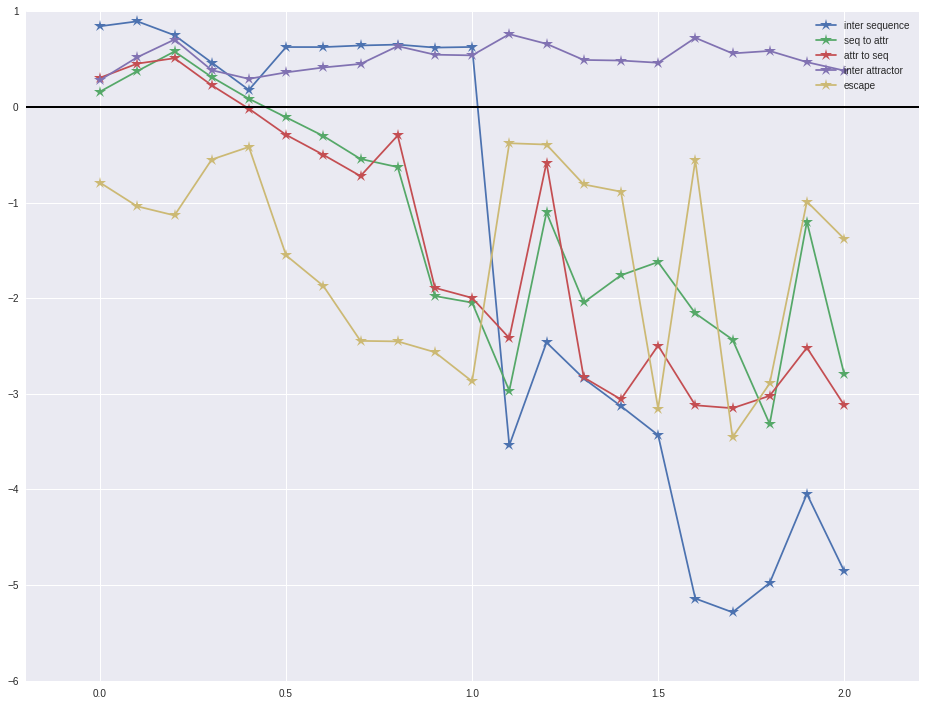

In [22]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(inter_pulse_interval_ranges, inter_sequence_connectivity, '*-', markersize=12, label='inter sequence')
ax.plot(inter_pulse_interval_ranges, sequence_to_free_attractor_connectivity, '*-', markersize=12, label='seq to attr')
ax.plot(inter_pulse_interval_ranges, free_attractor_to_sequence_connectivity, '*-', markersize=12, label='attr to seq')
ax.plot(inter_pulse_interval_ranges, inter_free_attractor_connectiivty, '*-', markersize=12, label='inter attractor')
ax.plot(inter_pulse_interval_ranges, first_state_to_free_attractor_connectivity, '*-', markersize=12, label='escape')

ax.axhline(0, color='k', linewidth=2)

ax.set_xlim([-0.2, inter_pulse_interval_ranges[-1] + 0.2])
ax.legend()

print(recall)

#### Effect of p

In [23]:
normalize = True
ampa = False
k_inner = True
p = 0.0


inter_sequence_connectivity = []
sequence_to_free_attractor_connectivity = []
free_attractor_to_sequence_connectivity = []
inter_free_attractor_connectiivty = []
first_state_to_free_attractor_connectivity = []
recall = []

for inter_pulse_interval in inter_pulse_interval_ranges:
    # Build the network
    nn = BCPNNFast(hypercolumns, minicolumns, k_inner=k_inner, p=p)

    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
    
    # Build the protocol for training
    protocol = Protocol()
    protocol.simple_protocol(patterns, training_time=training_time, inter_pulse_interval=inter_pulse_interval,
                             inter_sequence_interval=inter_sequence_interval, epochs=epochs)

    # Train
    manager.run_network_protocol(protocol=protocol, verbose=False)

    # Calculate the connections
    total = calculate_total_connections(manager, 0, 1, ampa=ampa, normalize=normalize)
    seq_to_attractor = calculate_connections_last_pattern_to_free_attractor(manager, ampa=ampa, normalize=normalize)
    attractor_to_seq = calculate_connections_free_attractor_to_first_pattern(manager, ampa=ampa, normalize=normalize)
    inter_free_attractor = calculate_connections_among_free_attractor(manager, ampa=ampa, normalize=normalize)
    aux = calculate_connections_first_pattern_to_free_attractor(manager, ampa=ampa, normalize=normalize)

    inter_sequence_connectivity.append(total)
    sequence_to_free_attractor_connectivity.append(seq_to_attractor)
    free_attractor_to_sequence_connectivity.append(attractor_to_seq)
    inter_free_attractor_connectiivty.append(inter_free_attractor)
    first_state_to_free_attractor_connectivity.append(aux)
    
    # Calculate correct recall
    pattern = [0, 1, 2, 3, 4]
    success_rate = calculate_recall_sucess(manager, T_recalling=T_recalling,
                                      I_cue=patterns[0], T_cue=0.1, n=10, pattern=pattern)
    recall.append([inter_pulse_interval, success_rate])

[[0.0, 50.0], [0.10000000000000001, 100.0], [0.20000000000000001, 70.0], [0.30000000000000004, 10.0], [0.40000000000000002, 10.0], [0.5, 0.0], [0.60000000000000009, 20.0], [0.70000000000000007, 0.0], [0.80000000000000004, 0.0], [0.90000000000000002, 0.0], [1.0, 0.0], [1.1000000000000001, 0.0], [1.2000000000000002, 0.0], [1.3, 0.0], [1.4000000000000001, 0.0], [1.5, 0.0], [1.6000000000000001, 0.0], [1.7000000000000002, 0.0], [1.8, 0.0], [1.9000000000000001, 0.0], [2.0, 0.0]]


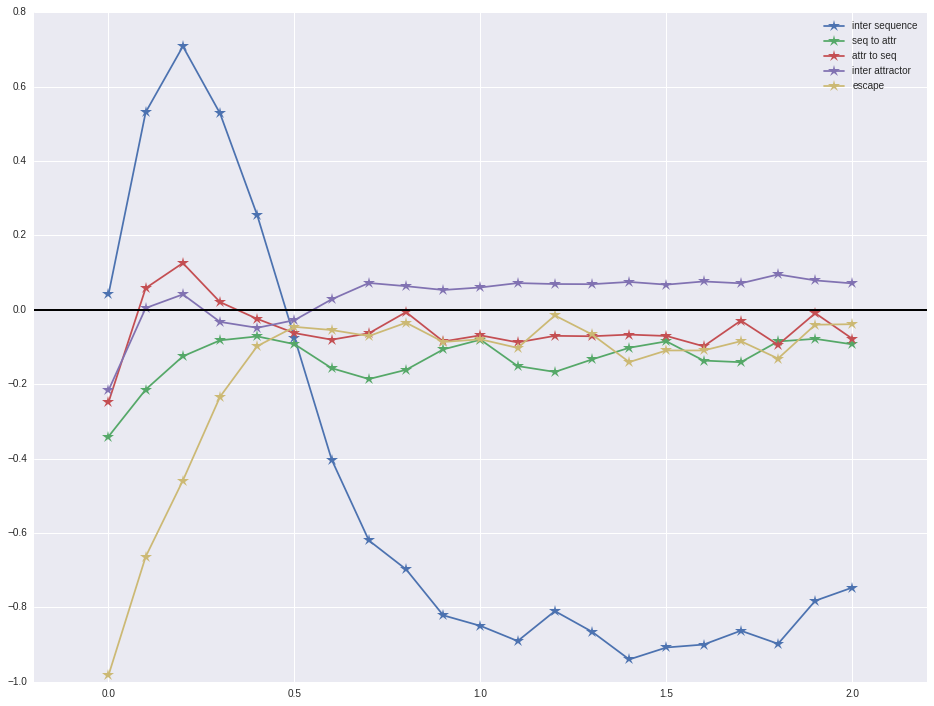

In [24]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(inter_pulse_interval_ranges, inter_sequence_connectivity, '*-', markersize=12, label='inter sequence')
ax.plot(inter_pulse_interval_ranges, sequence_to_free_attractor_connectivity, '*-', markersize=12, label='seq to attr')
ax.plot(inter_pulse_interval_ranges, free_attractor_to_sequence_connectivity, '*-', markersize=12, label='attr to seq')
ax.plot(inter_pulse_interval_ranges, inter_free_attractor_connectiivty, '*-', markersize=12, label='inter attractor')
ax.plot(inter_pulse_interval_ranges, first_state_to_free_attractor_connectivity, '*-', markersize=12, label='escape')

ax.axhline(0, color='k', linewidth=2)

ax.set_xlim([-0.2, inter_pulse_interval_ranges[-1] + 0.2])
ax.legend()

print(recall)

## Network size

In [25]:
# Patterns parameters
hypercolumns = 4
minicolumns = 10
n_patterns = 5  # Number of patterns

# Manager properties
dt = 0.001
T_recalling = 3.0
values_to_save = ['o']

# Protocol
training_time = 0.1
inter_sequence_interval = 0.5
inter_pulse_interval = 0.0
epochs = 5

# Build patterns
patterns_dic = build_ortogonal_patterns(hypercolumns, minicolumns)
patterns = list(patterns_dic.values())
patterns = patterns[:n_patterns]

minicolumns_range = np.arange(10, 50, 5)

In [26]:
normalize = True
ampa = False
k_inner = False
p = 1.0

inter_sequence_connectivity = []
sequence_to_free_attractor_connectivity = []
free_attractor_to_sequence_connectivity = []
inter_free_attractor_connectiivty = []
first_state_to_free_attractor_connectivity = []
recall = []

for minicolumns in minicolumns_range:
    
    n_patterns = int(minicolumns / 2)
    
    # Build patterns
    patterns_dic = build_ortogonal_patterns(hypercolumns, minicolumns)
    patterns = list(patterns_dic.values())
    patterns = patterns[:n_patterns]
    
    # Build the network
    nn = BCPNNFast(hypercolumns, minicolumns, k_inner=k_inner, p=p)

    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
    
    # Build the protocol for training
    protocol = Protocol()
    protocol.simple_protocol(patterns, training_time=training_time, inter_pulse_interval=inter_pulse_interval,
                             inter_sequence_interval=inter_sequence_interval, epochs=epochs)

    # Train
    manager.run_network_protocol(protocol=protocol, verbose=False)

    # Calculate the connections
    total = calculate_total_connections(manager, 0, 1, ampa=ampa, normalize=normalize)
    seq_to_attractor = calculate_connections_last_pattern_to_free_attractor(manager, ampa=ampa, normalize=normalize)
    attractor_to_seq = calculate_connections_free_attractor_to_first_pattern(manager, ampa=ampa, normalize=normalize)
    inter_free_attractor = calculate_connections_among_free_attractor(manager, ampa=ampa, normalize=normalize)
    aux = calculate_connections_first_pattern_to_free_attractor(manager, ampa=ampa, normalize=normalize)

    inter_sequence_connectivity.append(total)
    sequence_to_free_attractor_connectivity.append(seq_to_attractor)
    free_attractor_to_sequence_connectivity.append(attractor_to_seq)
    inter_free_attractor_connectiivty.append(inter_free_attractor)
    first_state_to_free_attractor_connectivity.append(aux)
    
    # Calculate correct recall
    pattern = [i for i in range(n_patterns)]
    success_rate = calculate_recall_sucess(manager, T_recalling=T_recalling,
                                      I_cue=patterns[0], T_cue=0.1, n=10, pattern=pattern)
    recall.append([minicolumns, success_rate])

minicoluns range [10 15 20 25 30 35 40 45]
succesfully recalled [[10, 100.0], [15, 100.0], [20, 100.0], [25, 0.0], [30, 0.0], [35, 0.0], [40, 0.0], [45, 0.0]]


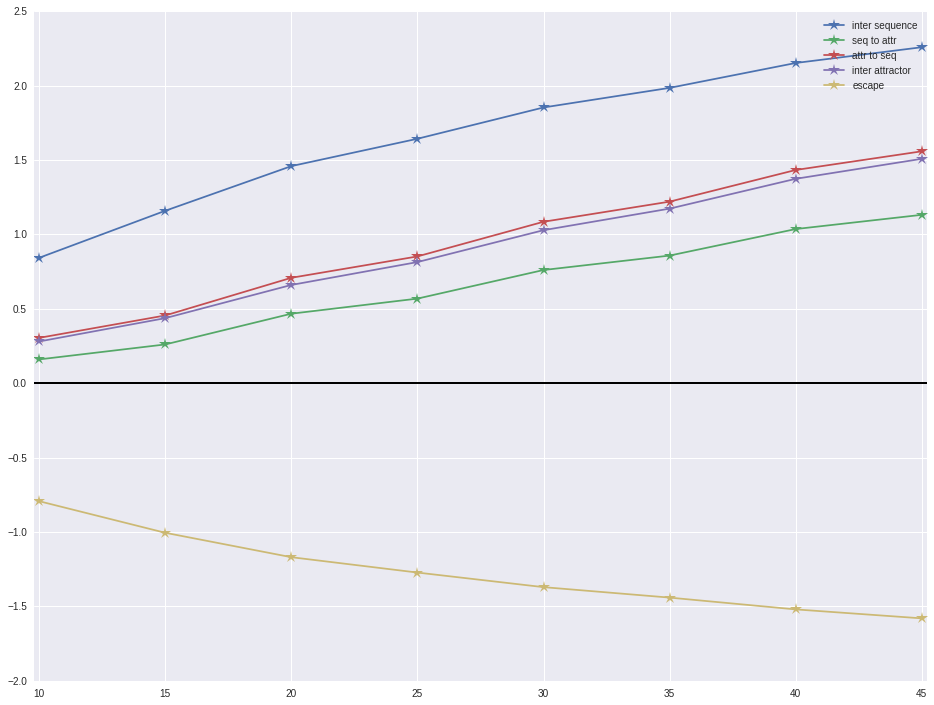

In [27]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(minicolumns_range, inter_sequence_connectivity, '*-', markersize=12, label='inter sequence')
ax.plot(minicolumns_range, sequence_to_free_attractor_connectivity, '*-', markersize=12, label='seq to attr')
ax.plot(minicolumns_range, free_attractor_to_sequence_connectivity, '*-', markersize=12, label='attr to seq')
ax.plot(minicolumns_range, inter_free_attractor_connectiivty, '*-', markersize=12, label='inter attractor')
ax.plot(minicolumns_range, first_state_to_free_attractor_connectivity, '*-', markersize=12, label='escape')

ax.axhline(0, color='k', linewidth=2)

ax.set_xlim([minicolumns_range[0] - 0.2, minicolumns_range[-1] + 0.2])
ax.legend()

print('minicoluns range', minicolumns_range)
print('succesfully recalled', recall)

#### Effect of k_inner

In [28]:
normalize = True
ampa = False
k_inner = False
p = 1.0

inter_sequence_connectivity = []
sequence_to_free_attractor_connectivity = []
free_attractor_to_sequence_connectivity = []
inter_free_attractor_connectiivty = []
first_state_to_free_attractor_connectivity = []
recall = []

for minicolumns in minicolumns_range:
    
    n_patterns = int(minicolumns / 2)
    
    # Build patterns
    patterns_dic = build_ortogonal_patterns(hypercolumns, minicolumns)
    patterns = list(patterns_dic.values())
    patterns = patterns[:n_patterns]
    
    # Build the network
    nn = BCPNNFast(hypercolumns, minicolumns, k_inner=k_inner, p=p)

    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
    
    # Build the protocol for training
    protocol = Protocol()
    protocol.simple_protocol(patterns, training_time=training_time, inter_pulse_interval=inter_pulse_interval,
                             inter_sequence_interval=inter_sequence_interval, epochs=epochs)

    # Train
    manager.run_network_protocol(protocol=protocol, verbose=False)

    # Calculate the connections
    total = calculate_total_connections(manager, 0, 1, ampa=ampa, normalize=normalize)
    seq_to_attractor = calculate_connections_last_pattern_to_free_attractor(manager, ampa=ampa, normalize=normalize)
    attractor_to_seq = calculate_connections_free_attractor_to_first_pattern(manager, ampa=ampa, normalize=normalize)
    inter_free_attractor = calculate_connections_among_free_attractor(manager, ampa=ampa, normalize=normalize)
    aux = calculate_connections_first_pattern_to_free_attractor(manager, ampa=ampa, normalize=normalize)

    inter_sequence_connectivity.append(total)
    sequence_to_free_attractor_connectivity.append(seq_to_attractor)
    free_attractor_to_sequence_connectivity.append(attractor_to_seq)
    inter_free_attractor_connectiivty.append(inter_free_attractor)
    first_state_to_free_attractor_connectivity.append(aux)
    
    # Calculate correct recall
    pattern = [i for i in range(n_patterns)]
    success_rate = calculate_recall_sucess(manager, T_recalling=T_recalling,
                                      I_cue=patterns[0], T_cue=0.1, n=10, pattern=pattern)
    recall.append([minicolumns, success_rate])

minicoluns range [10 15 20 25 30 35 40 45]
succesfully recalled [[10, 100.0], [15, 100.0], [20, 100.0], [25, 0.0], [30, 0.0], [35, 0.0], [40, 0.0], [45, 0.0]]


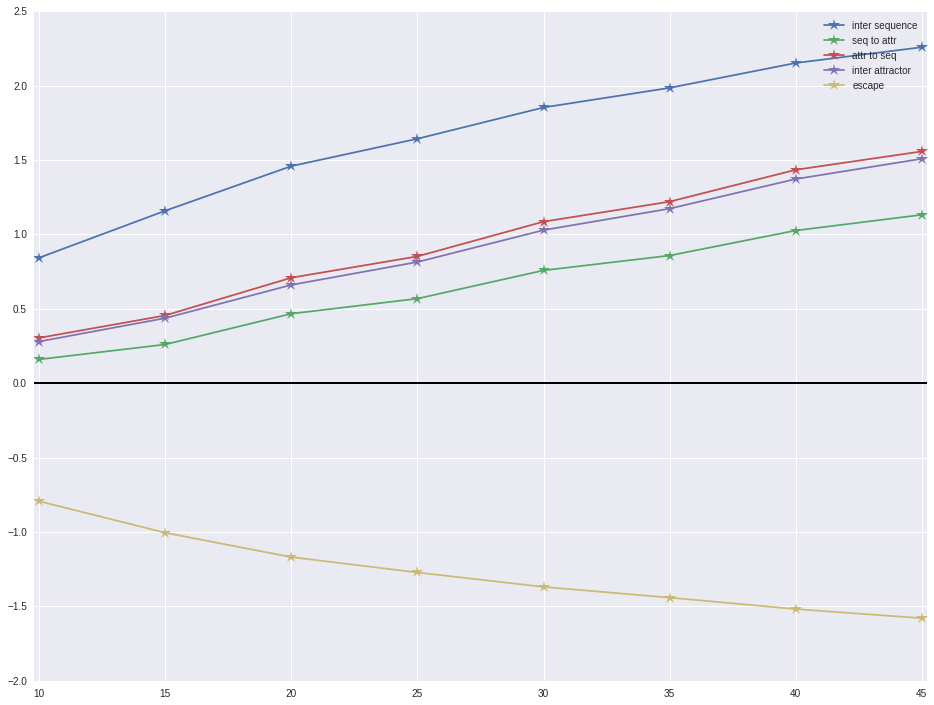

In [29]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(minicolumns_range, inter_sequence_connectivity, '*-', markersize=12, label='inter sequence')
ax.plot(minicolumns_range, sequence_to_free_attractor_connectivity, '*-', markersize=12, label='seq to attr')
ax.plot(minicolumns_range, free_attractor_to_sequence_connectivity, '*-', markersize=12, label='attr to seq')
ax.plot(minicolumns_range, inter_free_attractor_connectiivty, '*-', markersize=12, label='inter attractor')
ax.plot(minicolumns_range, first_state_to_free_attractor_connectivity, '*-', markersize=12, label='escape')

ax.axhline(0, color='k', linewidth=2)

ax.set_xlim([minicolumns_range[0] - 0.2, minicolumns_range[-1] + 0.2])
ax.legend()

print('minicoluns range', minicolumns_range)
print('succesfully recalled', recall)

#### Effect of fixed n_patterns (k_inner = True)

In [30]:
normalize = True
ampa = False
k_inner = True
p = 1.0

inter_sequence_connectivity = []
sequence_to_free_attractor_connectivity = []
free_attractor_to_sequence_connectivity = []
inter_free_attractor_connectiivty = []
first_state_to_free_attractor_connectivity = []
recall = []

n_patterns = 5

for minicolumns in minicolumns_range:
    
    
    # Build patterns
    patterns_dic = build_ortogonal_patterns(hypercolumns, minicolumns)
    patterns = list(patterns_dic.values())
    patterns = patterns[:n_patterns]
    
    # Build the network
    nn = BCPNNFast(hypercolumns, minicolumns, k_inner=k_inner, p=p)

    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
    
    # Build the protocol for training
    protocol = Protocol()
    protocol.simple_protocol(patterns, training_time=training_time, inter_pulse_interval=inter_pulse_interval,
                             inter_sequence_interval=inter_sequence_interval, epochs=epochs)

    # Train
    manager.run_network_protocol(protocol=protocol, verbose=False)

    # Calculate the connections
    total = calculate_total_connections(manager, 0, 1, ampa=ampa, normalize=normalize)
    seq_to_attractor = calculate_connections_last_pattern_to_free_attractor(manager, ampa=ampa, normalize=normalize)
    attractor_to_seq = calculate_connections_free_attractor_to_first_pattern(manager, ampa=ampa, normalize=normalize)
    inter_free_attractor = calculate_connections_among_free_attractor(manager, ampa=ampa, normalize=normalize)
    aux = calculate_connections_first_pattern_to_free_attractor(manager, ampa=ampa, normalize=normalize)

    inter_sequence_connectivity.append(total)
    sequence_to_free_attractor_connectivity.append(seq_to_attractor)
    free_attractor_to_sequence_connectivity.append(attractor_to_seq)
    inter_free_attractor_connectiivty.append(inter_free_attractor)
    first_state_to_free_attractor_connectivity.append(aux)
    
    # Calculate correct recall
    pattern = [i for i in range(n_patterns)]
    success_rate = calculate_recall_sucess(manager, T_recalling=T_recalling,
                                      I_cue=patterns[0], T_cue=0.1, n=10, pattern=pattern)
    recall.append([minicolumns, success_rate])

minicoluns range [10 15 20 25 30 35 40 45]
succesfully recalled [[10, 0.0], [15, 100.0], [20, 100.0], [25, 100.0], [30, 100.0], [35, 100.0], [40, 100.0], [45, 100.0]]


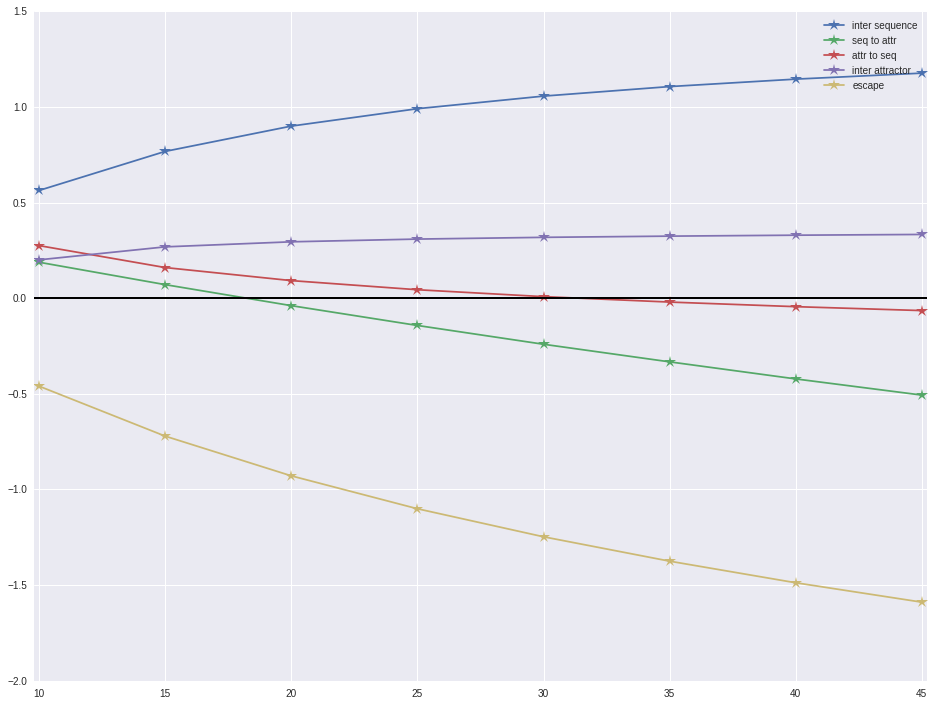

In [31]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(minicolumns_range, inter_sequence_connectivity, '*-', markersize=12, label='inter sequence')
ax.plot(minicolumns_range, sequence_to_free_attractor_connectivity, '*-', markersize=12, label='seq to attr')
ax.plot(minicolumns_range, free_attractor_to_sequence_connectivity, '*-', markersize=12, label='attr to seq')
ax.plot(minicolumns_range, inter_free_attractor_connectiivty, '*-', markersize=12, label='inter attractor')
ax.plot(minicolumns_range, first_state_to_free_attractor_connectivity, '*-', markersize=12, label='escape')

ax.axhline(0, color='k', linewidth=2)

ax.set_xlim([minicolumns_range[0] - 0.2, minicolumns_range[-1] + 0.2])
ax.legend()

print('minicoluns range', minicolumns_range)
print('succesfully recalled', recall)

#### Effect of fixed n_patterns (k_inner = False)

In [32]:
normalize = True
ampa = False
k_inner = False
p = 1.0

inter_sequence_connectivity = []
sequence_to_free_attractor_connectivity = []
free_attractor_to_sequence_connectivity = []
inter_free_attractor_connectiivty = []
first_state_to_free_attractor_connectivity = []
recall = []

n_patterns = 5

for minicolumns in minicolumns_range:
    
    
    # Build patterns
    patterns_dic = build_ortogonal_patterns(hypercolumns, minicolumns)
    patterns = list(patterns_dic.values())
    patterns = patterns[:n_patterns]
    
    # Build the network
    nn = BCPNNFast(hypercolumns, minicolumns, k_inner=k_inner, p=p)

    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
    
    # Build the protocol for training
    protocol = Protocol()
    protocol.simple_protocol(patterns, training_time=training_time, inter_pulse_interval=inter_pulse_interval,
                             inter_sequence_interval=inter_sequence_interval, epochs=epochs)

    # Train
    manager.run_network_protocol(protocol=protocol, verbose=False)

    # Calculate the connections
    total = calculate_total_connections(manager, 0, 1, ampa=ampa, normalize=normalize)
    seq_to_attractor = calculate_connections_last_pattern_to_free_attractor(manager, ampa=ampa, normalize=normalize)
    attractor_to_seq = calculate_connections_free_attractor_to_first_pattern(manager, ampa=ampa, normalize=normalize)
    inter_free_attractor = calculate_connections_among_free_attractor(manager, ampa=ampa, normalize=normalize)
    aux = calculate_connections_first_pattern_to_free_attractor(manager, ampa=ampa, normalize=normalize)

    inter_sequence_connectivity.append(total)
    sequence_to_free_attractor_connectivity.append(seq_to_attractor)
    free_attractor_to_sequence_connectivity.append(attractor_to_seq)
    inter_free_attractor_connectiivty.append(inter_free_attractor)
    first_state_to_free_attractor_connectivity.append(aux)
    
    # Calculate correct recall
    pattern = [i for i in range(n_patterns)]
    success_rate = calculate_recall_sucess(manager, T_recalling=T_recalling,
                                      I_cue=patterns[0], T_cue=0.1, n=10, pattern=pattern)
    recall.append([minicolumns, success_rate])

minicoluns range [10 15 20 25 30 35 40 45]
succesfully recalled [[10, 100.0], [15, 100.0], [20, 100.0], [25, 100.0], [30, 100.0], [35, 100.0], [40, 100.0], [45, 100.0]]


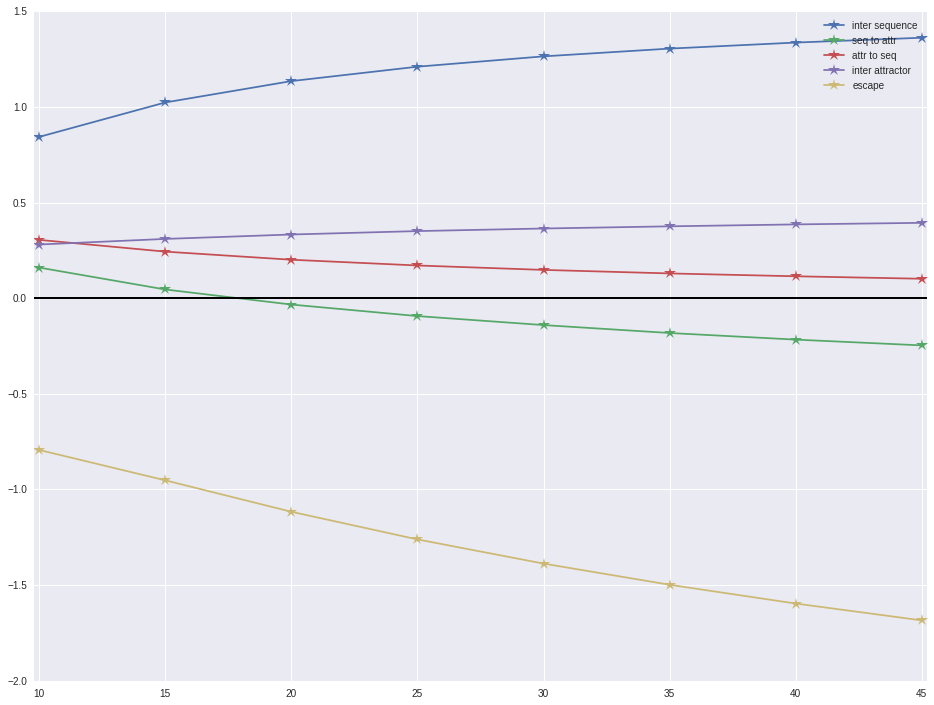

In [33]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(minicolumns_range, inter_sequence_connectivity, '*-', markersize=12, label='inter sequence')
ax.plot(minicolumns_range, sequence_to_free_attractor_connectivity, '*-', markersize=12, label='seq to attr')
ax.plot(minicolumns_range, free_attractor_to_sequence_connectivity, '*-', markersize=12, label='attr to seq')
ax.plot(minicolumns_range, inter_free_attractor_connectiivty, '*-', markersize=12, label='inter attractor')
ax.plot(minicolumns_range, first_state_to_free_attractor_connectivity, '*-', markersize=12, label='escape')

ax.axhline(0, color='k', linewidth=2)

ax.set_xlim([minicolumns_range[0] - 0.2, minicolumns_range[-1] + 0.2])
ax.legend()

print('minicoluns range', minicolumns_range)
print('succesfully recalled', recall)

## Free attractor size

In [34]:
# Patterns parameters
hypercolumns = 4
minicolumns = 50
n_patterns = 5  # Number of patterns

# Manager properties333333
dt = 0.001
T_recalling = 3.0
values_to_save = ['o']

# Protocol
training_time = 0.1
inter_sequence_interval = 0.5
inter_pulse_interval = 0.0
epochs = 5

# Build patterns
patterns_dic = build_ortogonal_patterns(hypercolumns, minicolumns)
patterns = list(patterns_dic.values())
patterns = patterns[:n_patterns]

n_patterns_range = np.arange(5, minicolumns + 5, 5)

In [35]:
normalize = True
ampa = False
k_inner = True
p = 1.0

inter_sequence_connectivity = []
sequence_to_free_attractor_connectivity = []
free_attractor_to_sequence_connectivity = []
inter_free_attractor_connectiivty = []
first_state_to_free_attractor_connectivity = []
recall = []

for n_patterns in n_patterns_range:
    
    # Build patterns
    patterns_dic = build_ortogonal_patterns(hypercolumns, minicolumns)
    patterns = list(patterns_dic.values())
    patterns = patterns[:n_patterns]
    
    # Build the network
    nn = BCPNNFast(hypercolumns, minicolumns, k_inner=k_inner, p=p)

    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
    
    # Build the protocol for training
    protocol = Protocol()
    protocol.simple_protocol(patterns, training_time=training_time, inter_pulse_interval=inter_pulse_interval,
                             inter_sequence_interval=inter_sequence_interval, epochs=epochs)

    # Train
    manager.run_network_protocol(protocol=protocol, verbose=False)

    # Calculate the connections
    total = calculate_total_connections(manager, 0, 1, ampa=ampa, normalize=normalize)
    seq_to_attractor = calculate_connections_last_pattern_to_free_attractor(manager, ampa=ampa, normalize=normalize)
    attractor_to_seq = calculate_connections_free_attractor_to_first_pattern(manager, ampa=ampa, normalize=normalize)
    inter_free_attractor = calculate_connections_among_free_attractor(manager, ampa=ampa, normalize=normalize)
    aux = calculate_connections_first_pattern_to_free_attractor(manager, ampa=ampa, normalize=normalize)

    inter_sequence_connectivity.append(total)
    sequence_to_free_attractor_connectivity.append(seq_to_attractor)
    free_attractor_to_sequence_connectivity.append(attractor_to_seq)
    inter_free_attractor_connectiivty.append(inter_free_attractor)
    first_state_to_free_attractor_connectivity.append(aux)
    
    # Calculate correct recall
    pattern = [i for i in range(n_patterns)]
    success_rate = calculate_recall_sucess(manager, T_recalling=T_recalling,
                                      I_cue=patterns[0], T_cue=0.1, n=10, pattern=pattern)
    recall.append([n_patterns, success_rate])

../analysis_functions.py:124: RuntimeWarning: invalid value encountered in double_scalars
  weights /= norm
../analysis_functions.py:144: RuntimeWarning: invalid value encountered in double_scalars
  weights /= norm
../analysis_functions.py:182: RuntimeWarning: invalid value encountered in double_scalars
  weights /= norm
../analysis_functions.py:164: RuntimeWarning: invalid value encountered in double_scalars
  weights /= norm


n_patterns range [ 5 10 15 20 25 30 35 40 45 50]
succesfully recalled [[50, 100.0], [50, 100.0], [50, 0.0], [50, 0.0], [50, 0.0], [50, 0.0], [50, 0.0], [50, 0.0], [50, 0.0], [50, 0.0]]


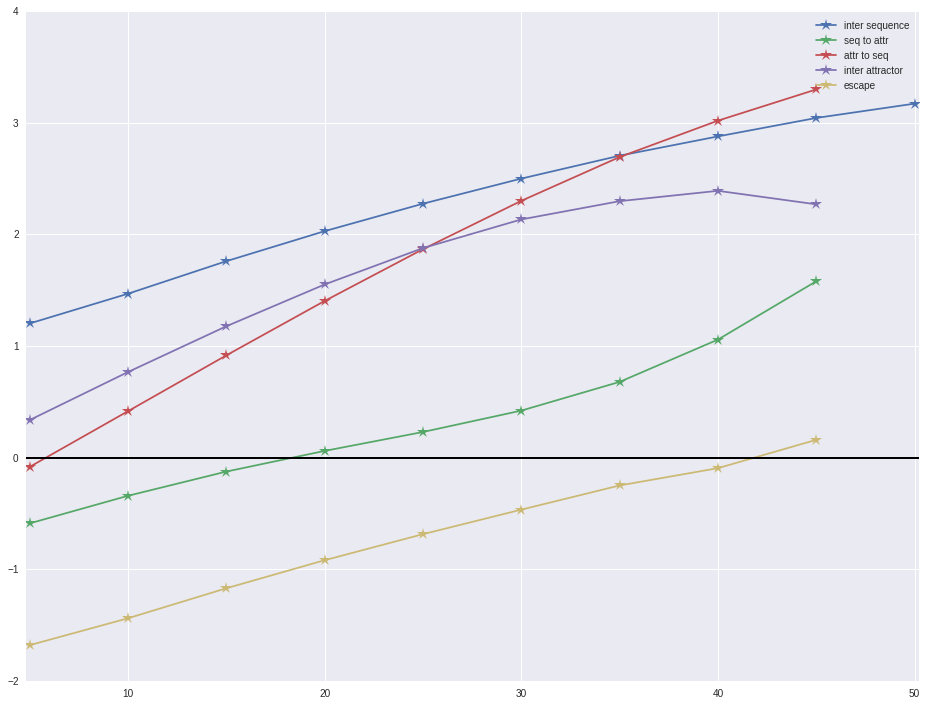

In [36]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(n_patterns_range, inter_sequence_connectivity, '*-', markersize=12, label='inter sequence')
ax.plot(n_patterns_range, sequence_to_free_attractor_connectivity, '*-', markersize=12, label='seq to attr')
ax.plot(n_patterns_range, free_attractor_to_sequence_connectivity, '*-', markersize=12, label='attr to seq')
ax.plot(n_patterns_range, inter_free_attractor_connectiivty, '*-', markersize=12, label='inter attractor')
ax.plot(n_patterns_range, first_state_to_free_attractor_connectivity, '*-', markersize=12, label='escape')

ax.axhline(0, color='k', linewidth=2)

ax.set_xlim([n_patterns_range[0] - 0.2, n_patterns_range[-1] + 0.2])
ax.legend()

print('n_patterns range', n_patterns_range)
print('succesfully recalled', recall)

#### Git recovery

In [37]:
if run_old_version:
    subprocess.call(['git', 'checkout', 'master'])